__Bipartite Graph Construction Based on Prototype:__
 * kmeans for prototyping ( select k prototypes)
 * construct Bipartite Graph based on Gaussian ( $ \sigma $ )
 * Laplacian and it's eigenvectors
 * new representation
 * test 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
%matplotlib inline

In [4]:
def generateTwoDisks():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)


    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Disks"

def generateTwoGaussian():
    mean1 = [-2, -2]
    cov1 = [[1, 0], [0, 1]]  # diagonal covariance
    mean2 = [2,2]
    cov2 = [[1, 0], [0, 1]]  # diagonal covariance

    # data
    x = np.zeros(200)
    y = np.zeros(200)
    label = np.zeros(200)
    x[:100], y[:100] = np.random.multivariate_normal(mean1, cov1, 100).T
    x[100:], y[100:] = np.random.multivariate_normal(mean2, cov2, 100).T
    label[100:] = np.ones(100)
    return x,y,label,"Gaussian"

def generateTwoParabola():
    x1 = np.linspace(-10, 10, 40)
    y1 = .22*x1**2 + .024*x1 + .04  

    x2 = np.linspace(0, 20, 40)
    y2 = -.2*(x2-10)**2 - .024*(x2-10) + 35

    size = x1.shape[0]
    EACH = 10
    X = np.zeros(2*size*EACH)
    Y = np.zeros(2*size*EACH)
    label = np.zeros(2*size*EACH)
    label[size*EACH:] = np.ones(size*EACH)

    cov = [[1, 0], [0, 1]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    return X,Y,label,"Parabolas"


def plotData(x,y,label,dataName):
    plt.plot(x[label==0], y[label==0], 'bo')
    plt.plot(x[label==1], y[label==1], 'ro')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()
colors = ['b', 'g', 'r', 'w', 'y']
def plotData2(x,y,label,dataName):
    num = len(np.unique(sorted(label)))
    for i in range(num):
        plt.plot(x[label==i], y[label==i], colors[i%5]+'o')
    plt.axis('equal')
    plt.savefig(dataName+'.jpg')
    plt.show()

<h2 style="color:red"> __Prototyping__ </h2>

In [5]:
def Prototyping(dataset,numP):
    kmeans = KMeans(init='k-means++',n_clusters=numP)
    kmeans.fit(dataset)

    print 'initiated clustered data:'
    plotData2(X,Y,kmeans.labels_,'a')

    centers = kmeans.cluster_centers_
    return centers


<h2 style="color:red"> Graph Construction </h2>

In [6]:



def distance2(p1,p2):
    return (p1[0]-p2[0])**2+(p1[1]-p2[1])**2
def similarity(p1,p2):
    sigma = 10
    return np.exp((-distance2(p1,p2)**2)/(2*(sigma**2)))


def constructBipartite(dataset,numS,centers,numP):
    N = numS + numP
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L

def constructSupervised(dataset,numS,centers,numP,labels):
    labelNodes = np.unique(sorted(labels))
    p1 = np.sum(labels)
    p0 = labels.shape[0] - p1
    P = [ 1.0/p0, 1.0/p1] 
    N = numS + numP + len(labels)
    # constructing graph
    W = np.zeros((N,N))
    for i in range(numS):
        for j in range(numP):
            W[i,j+numS] = similarity((dataset[i,0],dataset[i,1]),(centers[j,0],centers[j,1]))
            W[j+numS,i] = W[i,j+numS]

    for i in range(numS):
        W[i,numS+numP+labels[i]] = P[labels[i]]
        W[numS+numP+labels[i],i] = P[labels[i]]
    # construct laplacian
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    return W,D,L


<h2 style="color:red">__unnormalized laplacian method (1)__</h2>

In [7]:
def unnormalized(W,D,L):
    # find eigenvectors and eigenvalues
    eigenValues , eigenVectors = np.linalg.eig(L)
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Shi & Malik (2)__</h2>

In [8]:
import scipy as sp
def normalized2(W,D,L):
    N = W.shape[0]
    D = np.diag(np.dot(W,np.ones(N)))
    L = D - W
    eigenValues , eigenVectors = sp.linalg.eig(L,D)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

<h2 style="color:red">__normalized laplacian method - Ng & Jordan (2)__</h2>

In [73]:
def normalized3(W,D,L):
    N = W.shape[0]
    d = np.diag(D)
    d1 = 1/np.sqrt(d)
    D1 = np.diag(d1)
    Lsym = np.dot(np.dot(D1,L),D1)
    for i in range(D1.shape[0]):
        print D1[i,i],
#     for i in range(Lsym.shape[0]):
#         for j in range(Lsym.shape[1]):
#             print Lsym[i,j],
#         print
    print Lsym
    eigenValues , eigenVectors = np.linalg.eig(Lsym)
    eigenValues = eigenValues.real
    idx = eigenValues.argsort()
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues,eigenVectors

In [44]:
def eigPlot(eigenValues,eigenVectors,label,model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    N = eigenValues.shape[0]
    #1
    eig0 = (eigenVectors[:,0])[label == 0]
    eig1 = (eigenVectors[:,0])[label == 1]
    ax1.plot(range(len(eig0)),eig0,'bx')
    ax1.plot(range(len(eig0),N),eig1,'rx')
    ax1.text(.5,.9,'1st eigenVector',
            horizontalalignment='center',
            transform=ax1.transAxes)
    #2
    eig0 = (eigenVectors[:,1])[label == 0]
    eig1 = (eigenVectors[:,1])[label == 1]
    ax2.plot(range(len(eig0)),eig0,'bx')
    ax2.plot(range(len(eig0),N),eig1,'rx')
    ax2.text(.5,.9,'2nd eigenVector',
            horizontalalignment='center',
            transform=ax2.transAxes)
    #3
    eig0 = (eigenVectors[:,2])[label == 0]
    eig1 = (eigenVectors[:,2])[label == 1]
    ax3.plot(range(len(eig0)),eig0,'bx')
    ax3.plot(range(len(eig0),N),eig1,'rx')
    ax3.text(.5,.9,'3rd eigenVector',
            horizontalalignment='center',
            transform=ax3.transAxes)
    #4
    eig0 = (eigenVectors[:,3])[label == 0]
    eig1 = (eigenVectors[:,3])[label == 1]
    ax4.plot(range(len(eig0)),eig0,'bx')
    ax4.plot(range(len(eig0),N),eig1,'rx')
    ax4.text(.5,.9,'4th eigenVector',
            horizontalalignment='center',
            transform=ax4.transAxes)
    
    plt.savefig('eigenVectos '+model+'.jpg')
    plt.show()
    xt = eigenVectors[:,0]
    yt = eigenVectors[:,1]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation 2 '+model)
    plt.savefig('new representation 2 '+model+'.jpg')
    plt.show()
    
    
    xt = eigenVectors[:,2]
    yt = eigenVectors[:,3]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation '+model)
    plt.savefig('new representation '+model+'.jpg')
    plt.show()
    

    plt.plot(range(10),eigenValues[:10],'bo')
    plt.title('eigenValues '+model)
    
    plt.savefig('eigenValues '+model+'.jpg')
    plt.show()
    print eigenValues[:10]

<h1 style="color:purple">__Results__</h2>

<h2 style="color:red">__Two Gaussian__</h2>

first data:


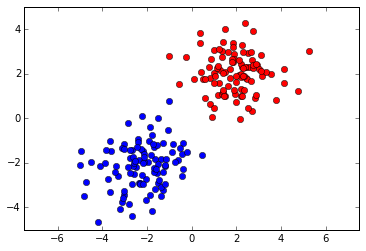

initiated clustered data:


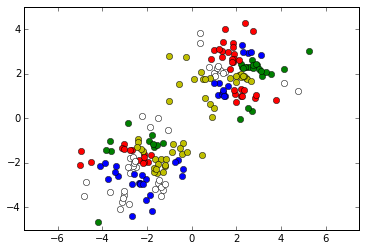

prototypes


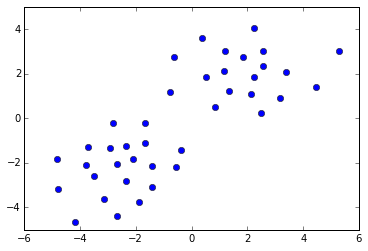

In [9]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoGaussian() #generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP


<h2 style="color:red">__Unnormalized Results__</h2>

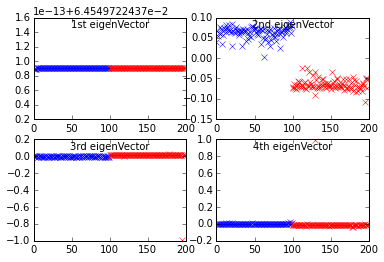

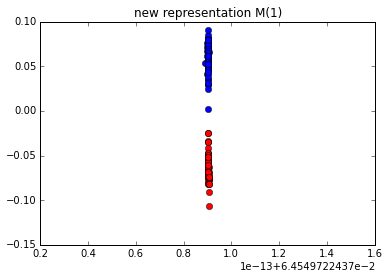

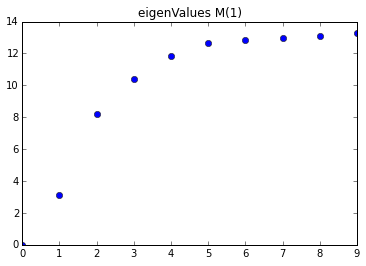

[  1.30373118e-15   3.11483694e+00   8.23026081e+00   1.04053409e+01
   1.18489518e+01   1.26719669e+01   1.28688470e+01   1.29837577e+01
   1.31053570e+01   1.32702531e+01]


In [10]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

c:\Anaconda\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


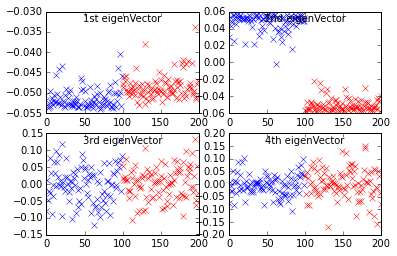

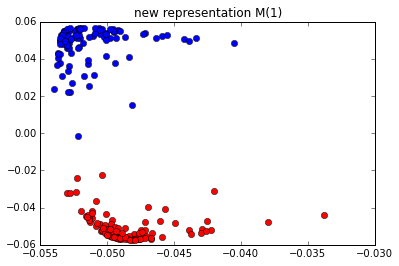

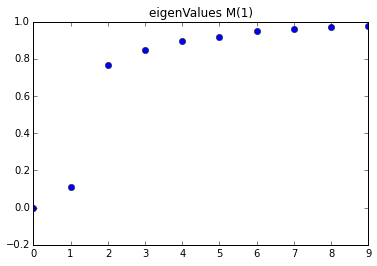

[ -6.77754070e-17   1.09676681e-01   7.67623395e-01   8.44777574e-01
   8.98248301e-01   9.16909871e-01   9.48124911e-01   9.59851833e-01
   9.72839802e-01   9.74075368e-01]


In [11]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Two Disks__</h2>


first data:


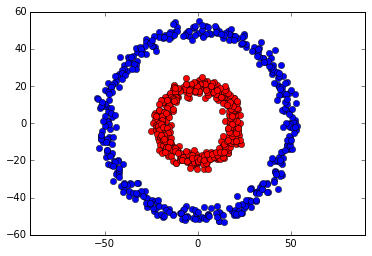

initiated clustered data:


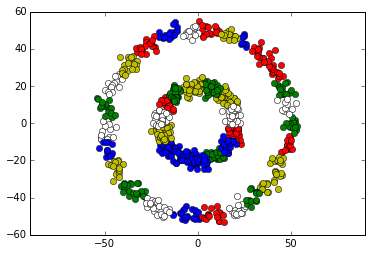

prototypes


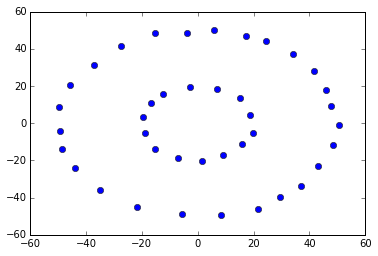

In [12]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoDisks()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

<h2 style="color:red">__Unnormalized Results__</h2>

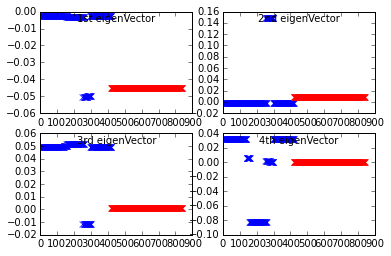

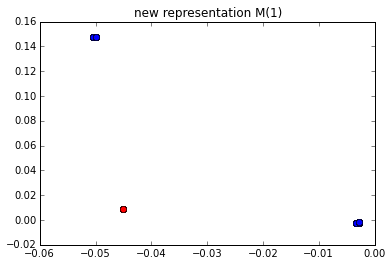

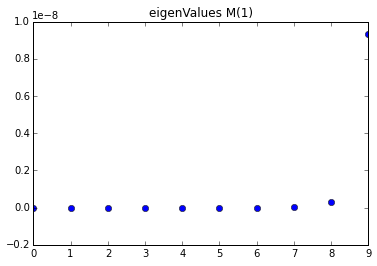

[ -1.80713832e-16  -1.54802374e-17   6.27350052e-16   1.38353767e-14
   4.69360984e-14   3.00812917e-13   1.50056336e-12   1.08293945e-11
   2.84923035e-10   9.34609908e-09]


In [13]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

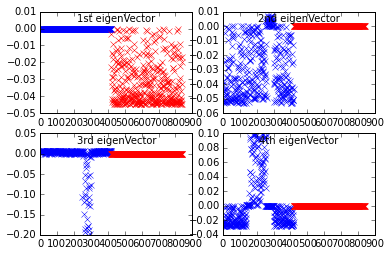

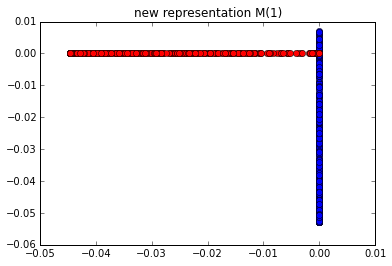

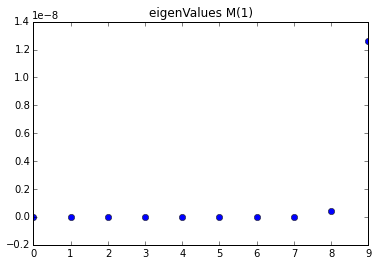

[ -3.31441910e-17   9.66329296e-17   2.21093080e-16   1.72076915e-14
   8.32903405e-14   3.98067941e-13   2.08239435e-12   1.09251234e-11
   4.22490263e-10   1.26432163e-08]


In [14]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Two Parabolas__</h2>


first data:


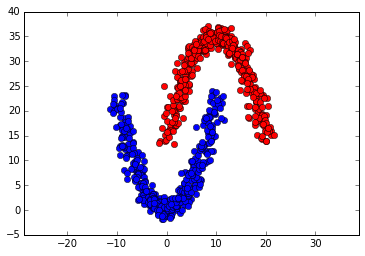

initiated clustered data:


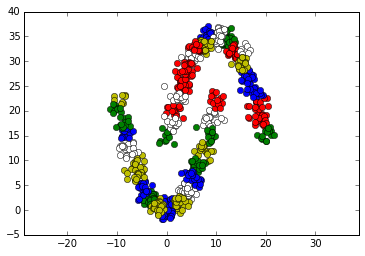

prototypes


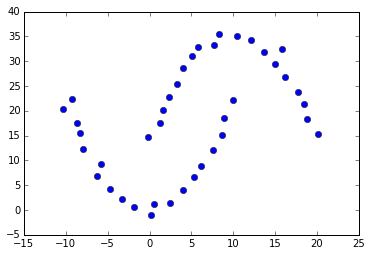

In [15]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoParabola()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

<h2 style="color:red">__Unnormalized Results__</h2>

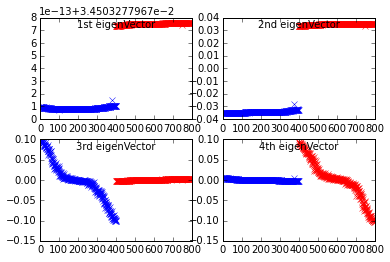

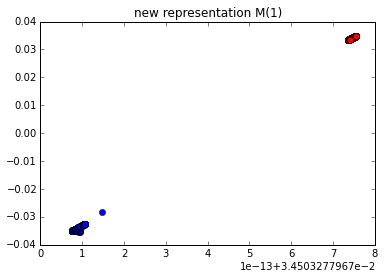

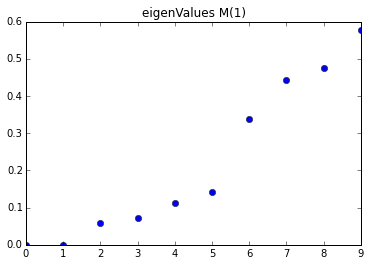

[  1.14061321e-14   6.24330877e-04   5.88580948e-02   7.27865559e-02
   1.11180802e-01   1.41995361e-01   3.37337455e-01   4.41723492e-01
   4.73985846e-01   5.77381805e-01]


In [16]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<h2 style="color:red">__Normalized Results__</h2>

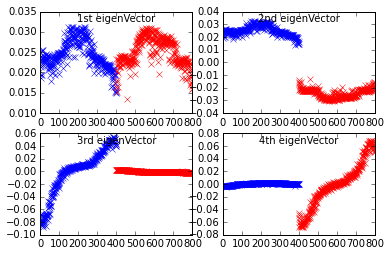

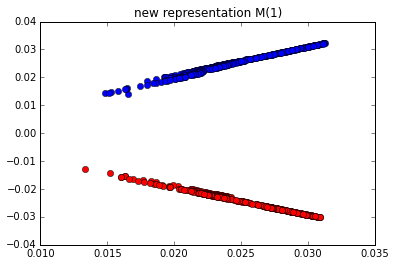

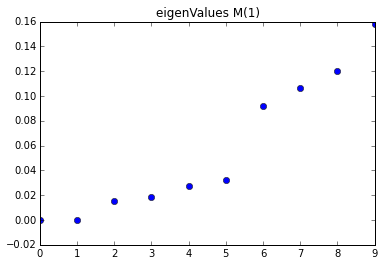

[ -4.12290307e-16   1.21286435e-04   1.56179269e-02   1.88796543e-02
   2.72714109e-02   3.25435596e-02   9.15346498e-02   1.06642120e-01
   1.20473941e-01   1.57703350e-01]


In [17]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

<b style="color:red">----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</b>

In [55]:
def eigPlot2(eigenValues,eigenVectors,label,model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    N = eigenValues.shape[0]
    #1
    eig0 = (eigenVectors[:,0])[label == 0]
    eig1 = (eigenVectors[:,0])[label == 1]
    ax1.plot(range(len(eig0)),eig0,'bx')
    ax1.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax1.text(.5,.9,'1st eigenVector',
            horizontalalignment='center',
            transform=ax1.transAxes)
    #2
    eig0 = (eigenVectors[:,1])[label == 0]
    eig1 = (eigenVectors[:,1])[label == 1]
    ax2.plot(range(len(eig0)),eig0,'bx')
    ax2.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax2.text(.5,.9,'2nd eigenVector',
            horizontalalignment='center',
            transform=ax2.transAxes)
    #3
    eig0 = (eigenVectors[:,2])[label == 0]
    eig1 = (eigenVectors[:,2])[label == 1]
    ax3.plot(range(len(eig0)),eig0,'bx')
    ax3.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax3.text(.5,.9,'3rd eigenVector',
            horizontalalignment='center',
            transform=ax3.transAxes)
    #4
    eig0 = (eigenVectors[:,3])[label == 0]
    eig1 = (eigenVectors[:,3])[label == 1]
    ax4.plot(range(len(eig0)),eig0,'bx')
    ax4.plot(range(len(eig0),len(eig0)+len(eig1)),eig1,'rx')
    ax4.text(.5,.9,'4th eigenVector',
            horizontalalignment='center',
            transform=ax4.transAxes)
    
    plt.savefig('eigenVectos '+model+'.jpg')
    plt.show()
    xt = eigenVectors[:,0]
    yt = eigenVectors[:,1]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation 2 '+model)
    plt.savefig('new representation 2 '+model+'.jpg')
    plt.show()
    
    
    xt = eigenVectors[:,2]
    yt = eigenVectors[:,3]
    plt.plot(xt[label==0], yt[label==0], 'bo')
    plt.plot(xt[label==1], yt[label==1], 'ro')

    plt.title('new representation '+model)
    plt.savefig('new representation '+model+'.jpg')
    plt.show()
    

    plt.plot(range(10),eigenValues[:10],'bo')
    plt.title('eigenValues '+model)
    
    plt.savefig('eigenValues '+model+'.jpg')
    plt.show()
    print eigenValues[:10]

In [61]:
def generateTwoDisksOutlier():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)

    OutlierNum = 60
    EACH = 10
    X = np.zeros(2*size*EACH+OutlierNum)
    Y = np.zeros(2*size*EACH+OutlierNum)
    label = np.ones(2*size*EACH+OutlierNum)
    label[size*EACH:2*size*EACH] = np.zeros(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    cov2 = [[1000,0],[0,1000]]
    X[2*size*EACH:],Y[2*size*EACH:] = np.random.multivariate_normal([0,0], cov2, OutlierNum).T
    label[2*size*EACH:] *= 2
    return X,Y,label,"Disks"

first data:


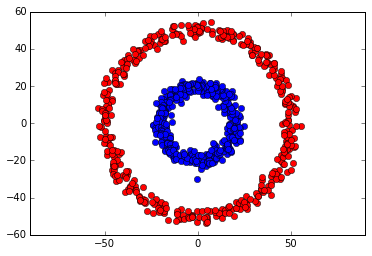

initiated clustered data:


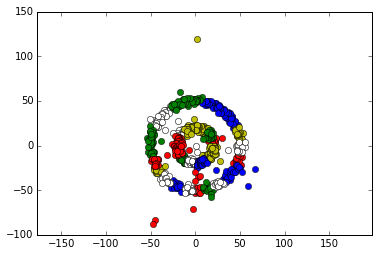

prototypes


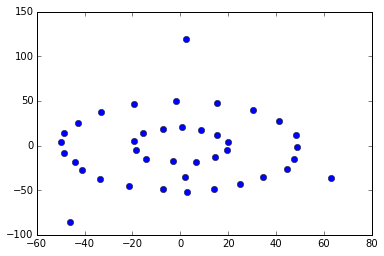

In [62]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoDisksOutlier()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

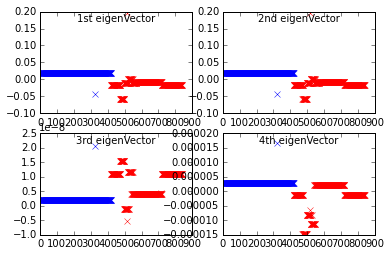

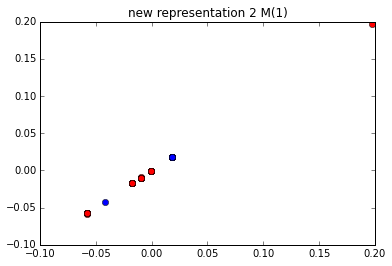

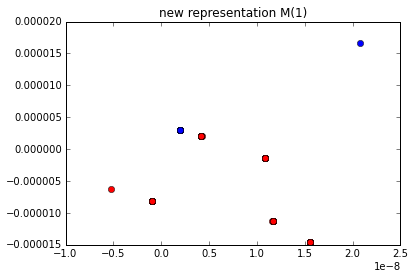

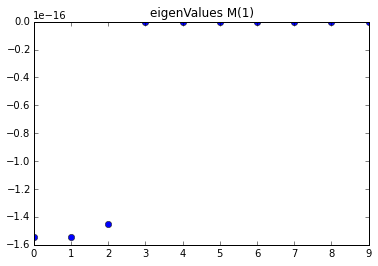

[ -1.54562733e-16 -5.50963241e-17j  -1.54562733e-16 +5.50963241e-17j
  -1.45286298e-16 +0.00000000e+00j  -2.14887967e-23 +0.00000000e+00j
  -9.11560004e-24 -1.01224804e-23j  -9.11560004e-24 +1.01224804e-23j
  -9.96396769e-25 -2.79849846e-24j  -9.96396769e-25 +2.79849846e-24j
  -9.92115089e-26 -5.38881091e-26j  -9.92115089e-26 +5.38881091e-26j]


In [63]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

In [64]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

LinAlgError: Array must not contain infs or NaNs

In [65]:
def generateTwoDisksOutlier2():
    angle = np.arange(0, np.pi*2, 0.15)

    r1 = 50
    r2 = 20
    size = angle.shape[0]

    x1 = r1 * np.cos(angle)
    y1 = r1 * np.sin(angle)

    x2 = r2 * np.cos(angle)
    y2 = r2 * np.sin(angle)

    OutlierNum = 60
    EACH = 10
    X = np.zeros(2*size*EACH+OutlierNum)
    Y = np.zeros(2*size*EACH+OutlierNum)
    label = np.ones(2*size*EACH+OutlierNum)
    label[size*EACH:2*size*EACH] = np.zeros(size*EACH)

    cov = [[5, 0], [0, 5]]  # diagonal covariance
    for i in range(size):
        X[i*EACH:(i+1)*EACH],Y[i*EACH:(i+1)*EACH] = np.random.multivariate_normal([x1[i],y1[i]], cov, EACH).T
        X[(i+size)*EACH:(i+size+1)*EACH],Y[(i+size)*EACH:(i+size+1)*EACH] = np.random.multivariate_normal([x2[i],y2[i]], cov, EACH).T
    cov2 = [[1000,0],[0,1000]]
    X[2*size*EACH:],Y[2*size*EACH:] = np.random.multivariate_normal([0,0], cov2, OutlierNum).T
    label[2*size*EACH:] *= 2
    return X,Y,label,"Disks"

first data:


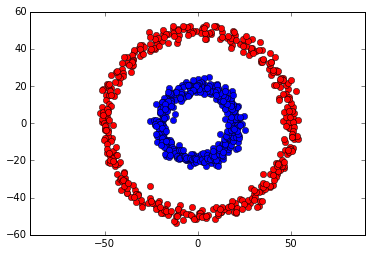

initiated clustered data:


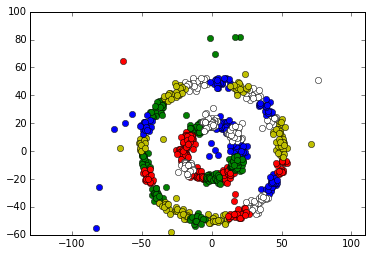

prototypes


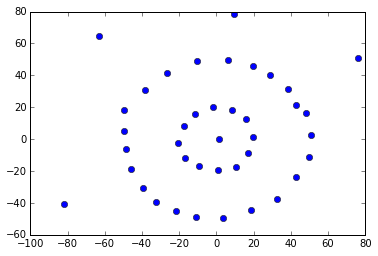

In [66]:
#prototyping
numP = 40

from sklearn.cluster import KMeans
X,Y,label,name = generateTwoDisksOutlier()
print 'first data:'
plotData(X,Y,label,name)

dataset = np.array([X, Y]).T
centers = Prototyping(dataset,numP)

print 'prototypes'
plt.plot(centers[:,0],centers[:,1],'bo')


numS = dataset.shape[0]
N = numS + numP

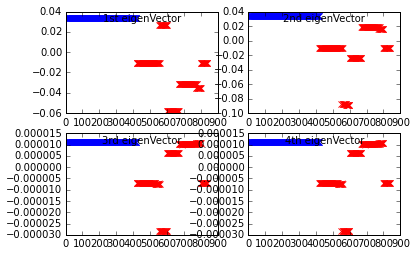

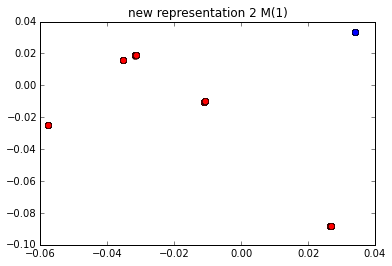

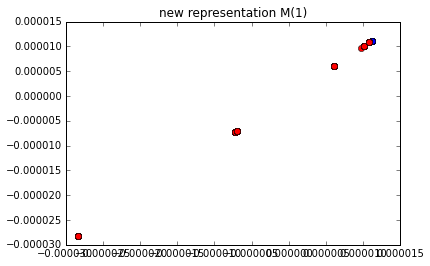

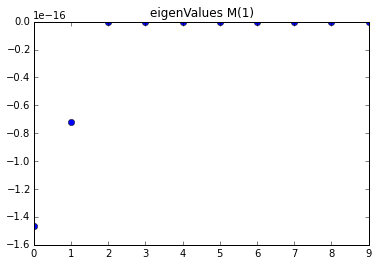

[ -1.46218942e-16 +0.00000000e+00j  -7.18256200e-17 +0.00000000e+00j
  -2.77483547e-22 -1.58805166e-22j  -2.77483547e-22 +1.58805166e-22j
  -2.01766613e-22 +0.00000000e+00j  -6.21926404e-23 -5.48094459e-23j
  -6.21926404e-23 +5.48094459e-23j  -2.38561268e-24 -2.01790462e-24j
  -2.38561268e-24 +2.01790462e-24j  -9.59234839e-25 -2.82450928e-25j]


In [67]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = unnormalized(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

In [74]:
W,D,L = constructBipartite(dataset,numS,centers,numP)
eigenValues,eigenVectors = normalized3(W,D,L)
eigPlot2(eigenValues[:numS],eigenVectors[:numS,:],label,'M(1)')

5.34034719365 1.03719334794 17.1390304582 1.87070053918 1.16777813399 1.00000696271 1.28394273041 1.07071458941 6.84455741831 1.55046929501 1.01069802068 16.2714111335 2.14860997313 18.5945214555 2.10756841532 1.24288630719 154.776274017 1.56327408367 2.2568925926 40.4455784664 1.04974284337 1.00283254786 1.08521742649 7.25634991362 22.9080824955 1.76825105185 1.44192056581 1.08807988578 1.36728820711 3.76541680469 2.24869257288 4.98904127117 1.00887777376 291.620808477 1.25367823926 1.09242369344 1.04317473917 1.00519531769 1.43531437784 1.35024285434 1.1543943487 5.99941056571 1.76625780413 2.39033195764 1.07128987551 9.61636826823 8.6673304444 2.28246625687 1.02533607559 1.25283904188 3.80909822697 1.00000177758 5.56547305065 1.00398959786 70.128189516 2.72266152415 13.7715916219 1.02536035225 3.40836316058 3.71900471415 1.16844104823 14.3241658681 8.01552589141 1.00000349336 1.00734285493 1.75218555404 1.00302351199 1.00003014046 2.16509486246 1.13490784097 1.42683143767 4.31221588

LinAlgError: Array must not contain infs or NaNs